# Testing PIDs

This notebook is for visual debugging of PID controllers. The PID controllers are built into Python libraries using a simple emulation layer for Arduino. The emulation layer can be found in the `emulation/` directory. Since PID controllers don't touch hardware it's really easy to compile them. 

In [1]:
!make

CFLAGS="-std=c++11 -DARDUINO=100 -I autopid_lib -Iemulation" python3 autopid_builder.py 


/home/maximus/Arduino/libs/FastPID/test/autopid_builder.py:3: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.sysconfig
/home/maximus/Arduino/libs/FastPID/test/autopid_builder.py:3: DeprecationWarning: The distutils.sysconfig module is deprecated, use sysconfig instead
  import distutils.sysconfig
running install
running build
running build_ext
running install_lib
running install_egg_info
Removing ./AutoPID-1.0.egg-info
Writing ./AutoPID-1.0.egg-info


Once built the four PIDs that can be compared are importable:

| Name | Notes | URL |
| --- | --- | --- | 
| `FastPID` | This implementation | https://github.com/mike-matera/FastPID | 
| `ArduinoPID` | The *gold standard* for Arduino PID controllers, uses `float` math.  | https://github.com/br3ttb/Arduino-PID-Library | 
| `AutoPID` | A PID library for Arduino has some problems. | https://github.com/r-downing/AutoPID | 
| `refpid` | A reference PID implementation written in Python | | 


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import FastPID
import ArduinoPID
import AutoPID
import refpid

from ipywidgets import interact

## Test Infrastructure 

This diagram of a PID controller is from [Wikipedia](https://en.wikipedia.org/wiki/PID_controller). It shows a system diagram. This document refers to parts of the system using the names in the diagram.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/PID_en.svg/600px-PID_en.svg.png?20160622101044)

The next cell implements a discreet plant process. The process is a "leaky bucket". It's value tends toward zero based on it's sole parameter. 

In [3]:
class plant_process:
    def __init__(self, alpha):
        self.value = 0 
        self.alpha = alpha

    def __call__(self, output):
        self.value -= (self.value * self.alpha)
        self.value += output 
        return round(self.value)

The next cell implements a generator that takes a `pid` implementation, a generator object for $r(t)$ and a function (or callable) for $y(t)$ as input. The function generates tuples of ($u(t)$, $y(t)$).

In [4]:
def simulate(pid, setpoint, plant):
    output = 0
    for sp in setpoint:
        feedback = plant(output)
        output = pid.step(sp, feedback)
        yield output, feedback

## Performance Against the Reference

This code tests a selected controller against the reference controller. 

In [5]:
@interact(p=(0,1,0.01), i=(0,1,0.01), d=(0,1,0.01), obits=[16,8,1], osign=True, n=(10,200,10), pid=['FastPID', 'ArduinoPID', 'AutoPID'])
def do_reference_fun(obits, osign, pid, p, i, d, n,):

    dut = eval(pid)
    dut.configure(p, i, d, obits, osign)
    ref = refpid.refpid(p, i, d, obits, osign)

    setpoint = [0, 0] + ([1000] * (n-2)) + ([-1000] * (n-2))

    reference = np.fromiter(simulate(ref, setpoint, plant_process(0.2)), dtype=np.dtype((int, 2)))
    output = np.fromiter(simulate(dut, setpoint, plant_process(0.2)), dtype=np.dtype((int, 2)))

    setline = plt.plot(setpoint, '', label='Setpoint')
    refline = plt.plot(reference[:,1], '--', label='Reference')
    outline = plt.plot(output[:,1], '', label=pid)
    plt.legend(['Setpoint r(t)', 'Reference y(t)', f"{pid} y(t)"])
    plt.xlabel('Time (Steps)')
    plt.ylabel('Codes')
    plt.title('{} vs. Reference (p={} i={} d={})'.format(pid, p, i, d))
    plt.show()

interactive(children=(Dropdown(description='obits', options=(16, 8, 1), value=16), Checkbox(value=True, descri…

## Testing the Parameter Domain

In FastPID the parameters are scaled from floats to integers to make the math faster. Configuring FastPID returns a boolean to indicate if there was an error that would cause the operation of the controller to fail. Because the logic is complicated, the next cell demonstrates the domain of the parameters based on search.

In [6]:

kp = 1
while FastPID.configure(kp-1,0,0,16,False) :
    okay = kp
    kp *= 2
print (f'The largest valid parameter: {okay}')

kp = 1
while FastPID.configure(kp,0,0,16,False) :
    okay = kp
    kp /= 2
print (f'The smallest valid parameter: {okay}')


The largest valid parameter: 256
The smallest valid parameter: 0.00390625


## AutoPID Has a Broken `D` Parameter 

The `AutoPID` doesn't seem to respond to changes in `D`.

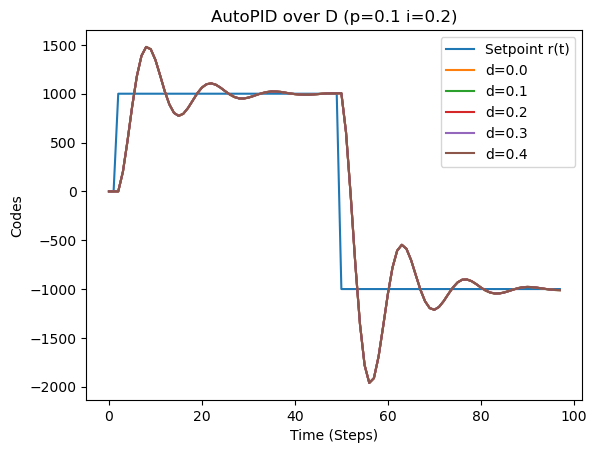

In [7]:
n = 50
obits = 16
osign = True 
p = 0.1
i = 0.2
d = 0.0

setpoint = [0, 0] + ([1000] * (n-2)) + ([-1000] * (n-2))
legend = ["Setpoint r(t)"]
plt.plot(setpoint, '', label='Setpoint')

for d in range(0,5):
    d /= 10
    AutoPID.configure(p, i, d, obits, osign)
    output = np.fromiter(simulate(AutoPID, setpoint, plant_process(0.2)), dtype=np.dtype((int, 2)))
    plt.plot(output[:,1], '', label=f'd={d}')
    legend += [f"d={d}"]
    
plt.legend(legend)
plt.xlabel('Time (Steps)')
plt.ylabel('Codes')
plt.title(f'AutoPID over D (p={p} i={i})')

plt.show()